In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn as sk
import warnings as warn
import glob, os, warnings
import datetime as dt
from contextlib import nullcontext

In [77]:
# Load in the data
# suppressing mixed type because there are null values
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    arrests = pd.read_csv("/content/sample_data/Arrests 2011-2025 (clean).csv")
#parses inconsistent date_time data. takes str as obj, returns datetime obj. wicked slow, but functional
def date_time(moment):
    moment = str(moment)
    #split into YYYY, MM, DD, HH:MM:SS or MM, DD, YYYY, HH:MM:SS
    pieces = moment.replace(" UTC", "").replace("/","-").strip().replace(" ", "-").split("-")

    #figure out which of the two formats this is
    year_ind = 2 if (len(pieces[0]) != 4) else  0

    #separate year, normalize formats
    year = int(pieces[year_ind])
    pieces.pop(year_ind)
    month = int(pieces[0])
    day = int(pieces[1])

    #handle blank timestamps, save to datetime obj & return
    return dt.datetime(year, month, day)
    arrests['Apprehension Date Time'] = arrests['Apprehension Date Time']

#normalize into datetime objects
arrests["Apprehension Date Time"] = arrests["Apprehension Date Time"].transform(date_time)

pd_monthly = arrests.sort_values(by=['Apprehension Date Time'])
pd_monthly["Apprehension Date Time"] = pd_monthly["Apprehension Date Time"].dt.strftime('%Y-%m')

In [78]:
ice_date = pd_monthly['Apprehension Date Time'].tolist()
ice_citizen = pd_monthly['Citizenship Country'].tolist()
ice_depart = pd_monthly['Departure Country'].tolist()
monthly_data = {'Date': [], 'Arrests': [], 'Deportations': [], 'Deportations to home country': [], 'Deportations elsewhere': [], 'Home country proportion': []}
pd_month = pd.DataFrame(data=monthly_data)
# Keeps track of the dates put in daiy_data to prevent repeating rows
used_dates = []
# Contains the total number of arrests made for each day
ice_arrests = []
# Contains the total number of deportations that have happened
# that result from arrests made that day
ice_deport = []
# Contains the total of deportations that go to the arrested
# persons' country of citizenship
ice_home = []
# Contains the total of deportations going to other countries
ice_else = []
# The proportion of deportations that go to the correct country
ice_proportion = []

The convert_month method requires a date taken from the apprehension_date column of the dataset that is being processed. It checks that it has not previously processed data for this date before by checking a list of dates that it adds to whenever it processes an apprehension date for the first time. If it has not processed data relating to this date before, it finds the indices of arrests on that day in the cleaned ICE data. It then finds the total number of arrests, arrests leading to a deportation, the total numbers of arrests leading to deportations that either deport to the deported persons' country of citizenship or not, and the proportion of deportation-resulting arrests that go to the deported persons' country of citizenship. It adds these to lists that will become columns of the daily_df dataframe afterwards.

In [79]:
# Takes all of the entries for each month
# and compresses them into a single row
def convert_month (apprehension_date):
  if not(apprehension_date in used_dates):
    used_dates.append(apprehension_date)
    index_list = []
    for index, date in enumerate(ice_date):
      if date == apprehension_date:
        index_list.append(index)
    citizen_list = []
    depart_list = []
    for index in index_list:
        citizen_list.append(ice_citizen[index])
        depart_list.append(ice_depart[index])
    home = 0
    apart = 0
    i = 0
    while i < len(index_list):
      if(not(pd.isnull(depart_list[i]))):
        if (citizen_list[i] == depart_list[i]):
          home += 1
        else:
          apart += 1
      i += 1
    ice_arrests.append(len(index_list))
    ice_deport.append(home+apart)
    ice_home.append(home)
    ice_else.append(apart)
    if home+apart>0:
      ice_proportion.append(home/(home+apart))
    else:
      ice_proportion.append(nullcontext)

In [80]:
for apprehension_date in ice_date:
  convert_month(apprehension_date)
# Move outcome to dataframe
pd_month['Date'] = used_dates
pd_month['Arrests'] = ice_arrests
pd_month['Deportations'] = ice_deport
pd_month['Deportations to home country'] = ice_home
pd_month['Deportations elsewhere'] = ice_else
pd_month['Home country proportion'] = ice_proportion


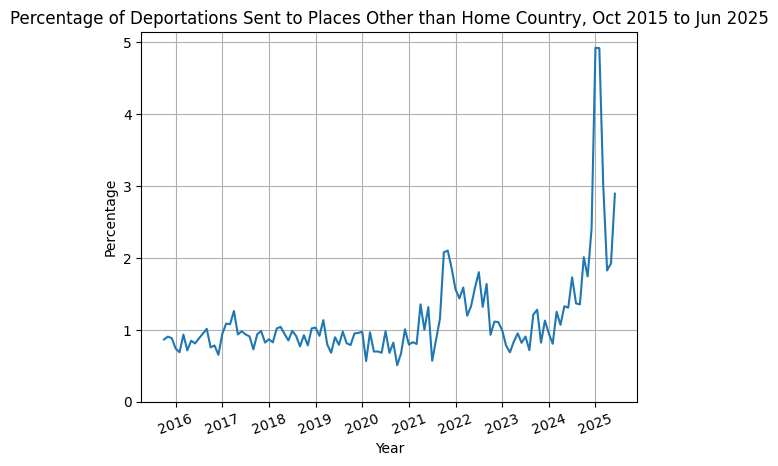

In [99]:
from pandas.io.formats.style_render import Subset
# Remove empty or partial entries
pd_prop = pd_month.iloc[24:].iloc[:-1]
x = pd_prop['Date']
y = (100-(pd_prop['Home country proportion']*100))
plt.plot(x,y)
plt.xlabel("Year")
plt.xticks(ticks = [3,15,27,39,51,63,75,87,99,111],
           labels = ["2016","2017","2018","2019","2020","2021","2022","2023","2024","2025"],
           rotation = 20)
plt.ylabel("Percentage")
plt.yticks(ticks = [0,1,2,3,4,5])
plt.title("Percentage of Deportations Sent to Places Other than Home Country, Oct 2015 to Jun 2025")
plt.grid(True)
plt.show()

Alt text: The graph is of the percentage of deportations resulting from arrests that are sent to the deported person's country of citizenship, which goes from October of 2015 to June in 2025. It is titled "Percentage of Deportations Sent to Places Other than Home Country, Oct 2015 to Jun 2025". The Y axis is labeled "Percentage", and runs from 0-5, and the X axis is labeled "Year", and marks years from slightly before 2016 (which is the first marked year) until halfway through 2025. The percentage stays relatively consistent at around 1% until late in 2021, where it rises to a little over 2%, then drops back down in late 2022. It then spikes to just over 5% right before 2025, before beginning to drop, then bounce back up. Given that any deportations are going to happen after arrests, the plot indicates that at the start of the second Trump administration, there was a massive spike in inaccuracy in deportation destination country.

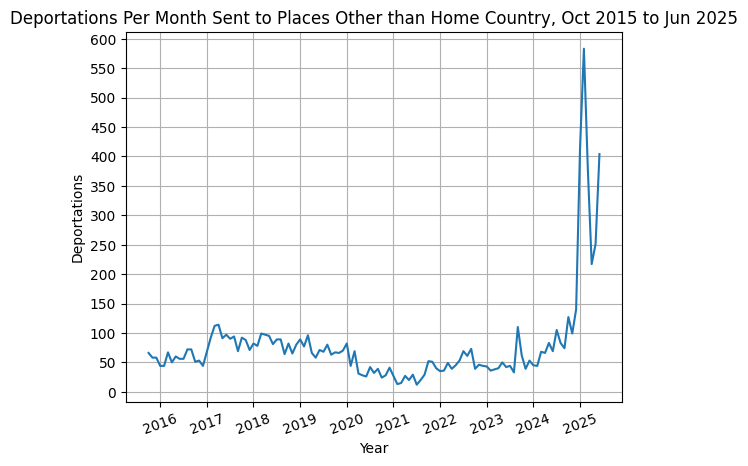

In [97]:
# Remove empty or partial entries
pd_prop = pd_month.iloc[24:].iloc[:-1]
x = pd_prop['Date']
y = pd_prop['Deportations elsewhere']
plt.plot(x,y)
plt.xlabel("Year")
plt.xticks(ticks = [3,15,27,39,51,63,75,87,99,111],
           labels = ["2016","2017","2018","2019","2020","2021","2022","2023","2024","2025"],
           rotation = 20)
plt.ylabel("Deportations")
plt.yticks(ticks = [0,50,100,150,200,250,300,350,400,450,500,550,600])
plt.title("Deportations Per Month Sent to Places Other than Home Country, Oct 2015 to Jun 2025")
plt.grid(True)
plt.show()

Alt text: the graph is titled "Deportations Per Month Sent to Places Other than Home Country, Oct 2015 to Jun 2025". The Y axis is labeled "Deportations", and is marked from 0 to 600. The X axis is labeled "Year", which runs from just before 2016 to mid 2025. The number of deportations stays between around 10-125 up until 2025, where it spikes up to almost 600, before falling to around 225 and rebounding back up to 400, where the graph ends. Given that the data tracks the deportations by arrest date, this indicates that there was a large spike in people sent to the wrong country right at the start of the Trump administration.

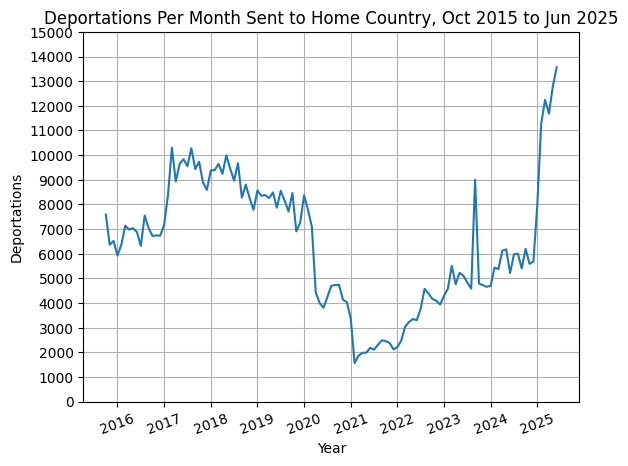

In [98]:
# Remove empty or partial entries
pd_prop = pd_month.iloc[24:].iloc[:-1]
x = pd_prop['Date']
y = pd_prop['Deportations to home country']
plt.plot(x,y)
plt.xlabel("Year")
plt.xticks(ticks = [3,15,27,39,51,63,75,87,99,111],
           labels = ["2016","2017","2018","2019","2020","2021","2022","2023","2024","2025"],
           rotation = 20)
plt.ylabel("Deportations")
plt.yticks(ticks = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000])
plt.title("Deportations Per Month Sent to Home Country, Oct 2015 to Jun 2025")
plt.grid(True)
plt.show()

Alt text: the graph is titled "Deportations Per Month Sent to Home Country, Oct 2015 to Jun 2025". The X axis is labeled "Year", and runs from mid 2015 to mid 2025. The Y axis is labeled "Deportations", and runs from 0 to 15000. The number of deportations to detainees' home countries starts at around 6000-7500 per month, then jumps to just over 10000 at 2017, then slowly drops to about 8000 until 2020. It then sharply drops, stopping at around 2000 in 2021. It slowly rises, very briefly spiking to 9000 in mid 2023, until it jumps all the way to around 13500 around the start of 2025. This supports the other data that shows a large spike in ICE activity at the start of the Trump administration.